In [1]:
from collections import Counter
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from ast import literal_eval
import json

In [13]:
file_name = "9M-5-[1-2001]-[firstpromo]-lcm.out"
output_file = f"queries_results/python_{file_name.replace('out','csv')}"

In [15]:
encoder = LabelEncoder()
encoder.classes_ = np.load(f'../../plots/encoders/{file_name}.npy')

def splited_links():
    links = pd.read_csv(f"../../plots/links/{file_name}")
    res = []
    links.apply(lambda x : [res.append((x["source"],x["target"], int(i) )) for i in x["user_id"].split(",")] ,axis=1)
    return  pd.DataFrame(res,columns=["source","target","user_id"])
def partial_df():
    # Groupes over two periods only
    links = splited_links()
    groups = pd.read_csv(f"../../plots/groups/{file_name}",index_col=0)
    groups.drop(["itemset_name","property_values"],axis=1,inplace=True)
    groups = groups.drop(['depth',"a","size","support",],axis=1)
    groups["itemsets"] = groups["itemsets"].apply(lambda x :set(encoder.inverse_transform([int(i) for i in x.split()])))
    groups["user_ids"] =  groups["user_ids"].apply(literal_eval)
    links = links.merge(groups.reset_index(),left_on="source",right_on='index').merge(groups.reset_index(),left_on="target",right_on='index')
    links.drop(["source","target","index_x","index_y","user_ids_x","user_ids_y"],axis=1,inplace=True)
    return links
def full_df():
    # Groups over three periods only
    links = splited_links()
    links = links.merge(links,left_on=["target","user_id"],right_on=["source","user_id"]).drop(["source_y"],axis=1)
    
    groups = pd.read_csv(f"../../plots/groups/{file_name}",index_col=0)
    groups.drop(["itemset_name","property_values","user_ids"],axis=1,inplace=True)
    groups = groups.drop(['depth',"firstpromo","size","support",],axis=1)
    groups["itemsets"] = groups["itemsets"].apply(lambda x :set(encoder.inverse_transform([int(i) for i in x.split()])))
    
    links = links.merge(groups,left_on="source_x",right_index=True).merge(groups,left_on="target_x",right_index=True).merge(groups,left_on="target_y",right_index=True)
    links = links.rename(columns={"itemsets":"itemsets_z","period":"period_z"})
    links.drop(["source_x","target_x","target_y"],axis=1,inplace=True)
    return links

with open("../../datasets/Total/ids_mapping.json","r") as file:
    mapping = json.load(file)
def extract_user_stats(x,columns):
    user = x["user_id"]
    for col in columns:
        for val in x[col]:
            res.append((user,col,val))

## Queries

In [27]:
df=full_df()
df.head()

,user_id,itemsets_x,period_x,itemsets_y,period_y,itemsets_z,period_z
0,157573,{3425909000482},2018-09-01,{3068320110783},2018-12-01,{3425909001007},2019-02-01
28,252901,{3425909000482},2018-09-01,{3068320110783},2018-12-01,{3425909001007},2019-02-01
1854,1068315,{3425909000482},2018-09-01,{3068320110783},2018-12-01,{3425909001007},2019-02-01
3,157573,{3425909000482},2018-09-01,{3068320110783},2018-12-01,{3425909001007},2019-02-01
34,252901,{3425909000482},2018-09-01,{3068320110783},2018-12-01,{3425909001007},2019-02-01


In [37]:
df["loyalty1"] = df.apply(lambda x: x["itemsets_y"].intersection(x["itemsets_x"]),axis=1)
df["loyalty2"] = df.apply(lambda x: x["itemsets_y"].intersection(x["itemsets_z"]),axis=1)

df["promo_exclusive_products"] = df.apply(lambda x : x["itemsets_y"].difference(x["itemsets_x"]).difference(x["itemsets_z"]),axis=1)
df["replacement"] = df.apply(lambda x : x["itemsets_x"].intersection(x["itemsets_y"]).difference(x["itemsets_z"]),axis=1)
df["loyalty"] = df.apply(lambda x :x["itemsets_x"].intersection(x["itemsets_y"].intersection(x["itemsets_z"])),axis=1)

In [36]:
df.loyalty1

0         {}
28        {}
1854      {}
3        NaN
34       NaN
        ... 
57148    NaN
57157    NaN
57166    NaN
57175    NaN
57193    NaN
Name: loyalty1, Length: 57546, dtype: object

# Stats

In [38]:
users= pd.read_csv("../../datasets/Total/users.csv",sep=";")
items = pd.read_csv("../../datasets/Total/items.csv",index_col=0).drop("IDS_LIST",axis=1)
res = []
queries_columns = df.columns.tolist()[7:]
df.apply(lambda x : extract_user_stats(x,queries_columns),axis=1)
stats_df = pd.DataFrame(res,columns=["CUST_ID","query_type","ARTICLE_ID"])
stats_df = stats_df.merge(users).merge(items)
stats_df.head(10)
# stats_df.to_csv("stats.csv")

,CUST_ID,query_type,ARTICLE_ID,SEX,AGE,DEPARTEMENT,DESCRIPTION
0,157573,promo_exclusive_products,3068320110783,F,50-65,06,EVIAN 50CL
1,157573,promo_exclusive_products,3068320110783,F,50-65,06,EVIAN 50CL
2,157573,promo_exclusive_products,3068320110783,F,50-65,06,EVIAN 50CL
3,157573,promo_exclusive_products,3068320110783,F,50-65,06,EVIAN 50CL
4,157573,promo_exclusive_products,3068320110783,F,50-65,06,EVIAN 50CL
5,157573,promo_exclusive_products,3068320110783,F,50-65,06,EVIAN 50CL
6,157573,promo_exclusive_products,3068320110783,F,50-65,06,EVIAN 50CL
7,157573,promo_exclusive_products,3068320110783,F,50-65,06,EVIAN 50CL
8,157573,promo_exclusive_products,3068320110783,F,50-65,06,EVIAN 50CL
9,157573,promo_exclusive_products,3068320110783,F,50-65,06,EVIAN 50CL


In [39]:
stats_df[stats_df.ARTICLE_ID==3439495300031].query_type.value_counts()

Series([], Name: query_type, dtype: int64)

### By users

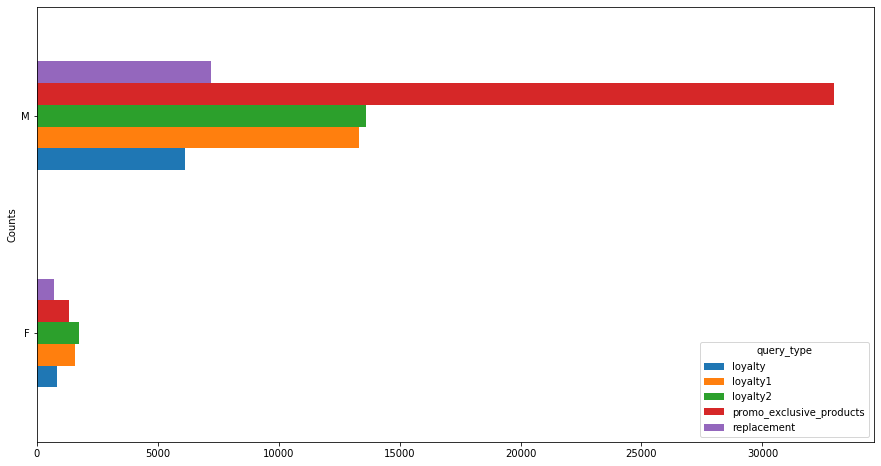

In [40]:
ax = stats_df.groupby(["SEX"])["query_type"].value_counts().unstack().plot(kind="barh",figsize=(15,8))
_= ax.set_ylabel("Counts")

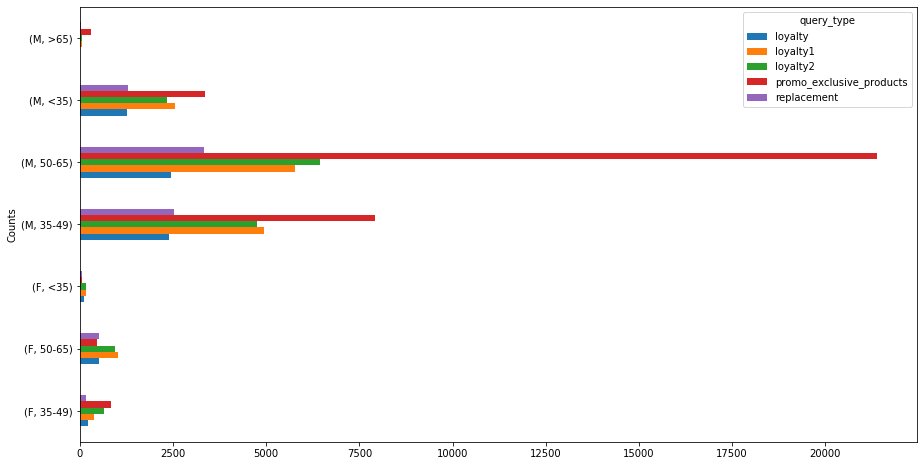

In [41]:
ax = stats_df.groupby(["SEX","AGE"])["query_type"].value_counts().unstack().plot(kind="barh",figsize=(15,8))
_= ax.set_ylabel("Counts")

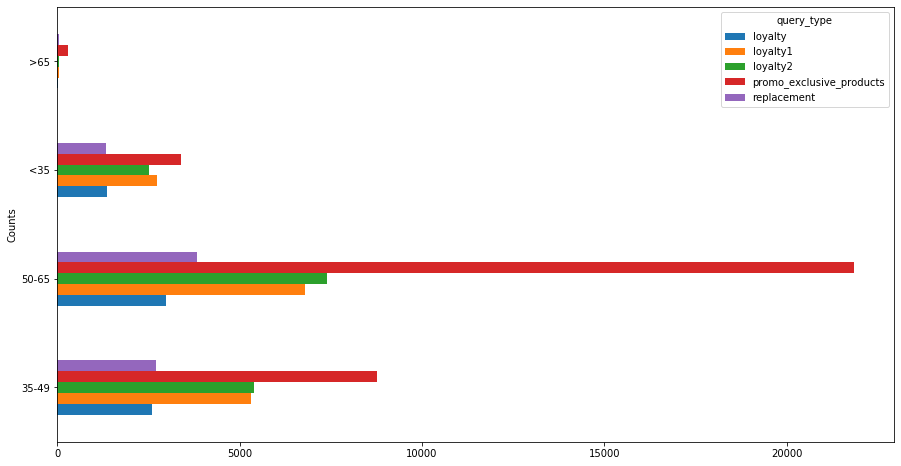

In [42]:
ax = stats_df.groupby(["AGE"])["query_type"].value_counts().unstack().plot(kind="barh",figsize=(15,8))
_= ax.set_ylabel("Counts")

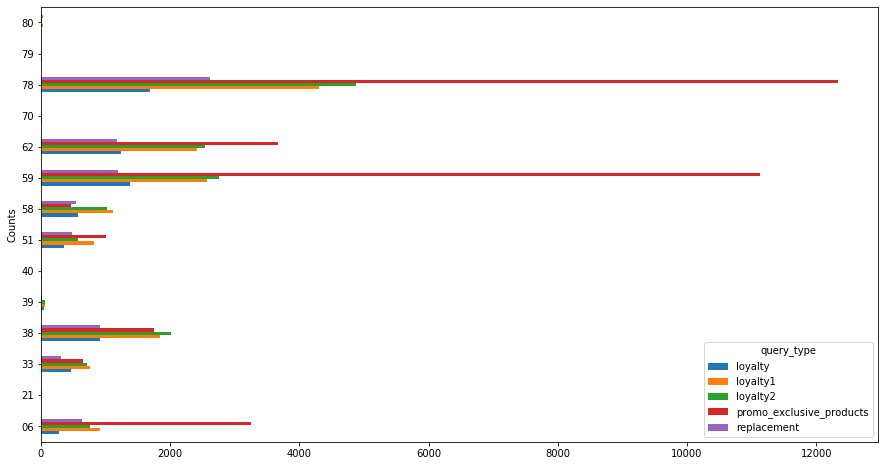

In [43]:
ax = stats_df.groupby(["DEPARTEMENT"])["query_type"].value_counts().unstack().plot(kind="barh",figsize=(15,8))
_= ax.set_ylabel("Counts")

### By items

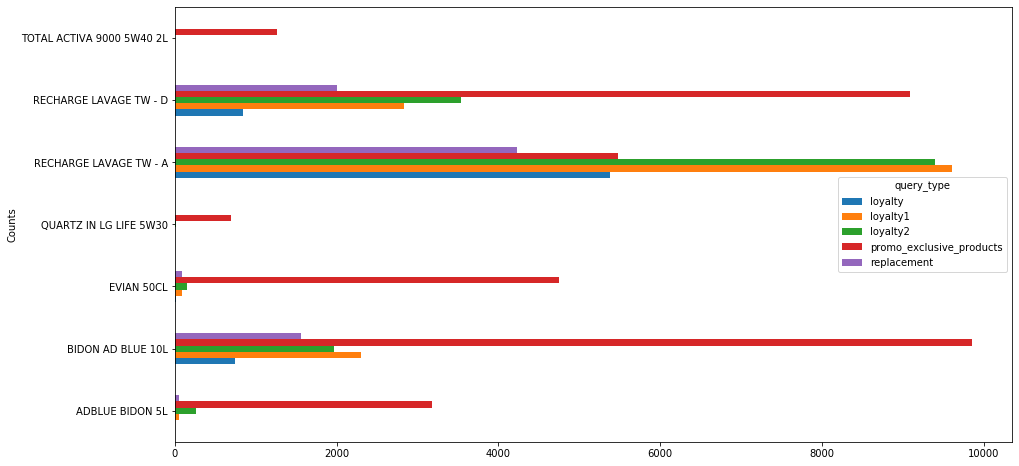

In [44]:
ax = stats_df.groupby(["DESCRIPTION"])["query_type"].value_counts().unstack().plot(kind="barh",figsize=(15,8))
_= ax.set_ylabel("Counts")

### DRAFT

In [25]:
groups = pd.read_csv(f"../../plots/groups/{file_name}",index_col=0)
groups.drop(["itemset_name","property_values"],axis=1,inplace=True)
groups[groups.itemsets.apply(lambda x : "4120" in x )]

,user_ids,support,itemsets,period,depth,size,a
543,"[135477, 156490, 164382, 179013, 185798, 19841...",58,4120,2018-09-01,0.000000,58,1
544,"[156490, 540071, 548581, 888898, 984812]",5,4120 4160,2018-09-01,0.000000,5,1
545,"[209038, 240151, 350965, 480899, 548581, 84523...",7,4120 3007,2018-09-01,0.000000,7,1
784,"[101105, 124784, 171396, 189197, 199984, 20903...",40,4120,2018-12-01,0.333333,40,1
1222,"[101205, 144221, 157796, 198410, 199984, 20903...",55,4120,2019-02-01,0.666667,55,1
1526,"[144221, 521161, 778698, 1189972, 1233005]",5,1857 4120,2019-02-01,0.666667,5,1


In [39]:
stats_df[(stats_df.ARTICLE_ID==3425909000796)&(stats_df.query_type=="loyalty")]

,CUST_ID,query_type,ARTICLE_ID,SEX,AGE,DEPARTEMENT,DESCRIPTION
8835,209038,loyalty,3425909000796,F,50-65,39,PROPANE 35KG FINAGAZ
8838,209038,loyalty,3425909000796,F,50-65,39,PROPANE 35KG FINAGAZ
8859,199984,loyalty,3425909000796,M,50-65,59,PROPANE 35KG FINAGAZ
9042,478604,loyalty,3425909000796,M,35-49,78,PROPANE 35KG FINAGAZ
9045,778698,loyalty,3425909000796,M,35-49,62,PROPANE 35KG FINAGAZ
9050,778698,loyalty,3425909000796,M,35-49,62,PROPANE 35KG FINAGAZ
9053,1236845,loyalty,3425909000796,M,50-65,62,PROPANE 35KG FINAGAZ


In [32]:
a = []
a.append(set.intersection(*[groups.loc[i].user_ids for i in [543,784,545]]))
a.append(set.intersection(*[groups.loc[i].user_ids for i in [543,784,1526]]))
        
a.append(set.intersection(*[groups.loc[i].user_ids for i in [544,784,545]]))
a.append(set.intersection(*[groups.loc[i].user_ids for i in [544,784,1526]]))

a.append(set.intersection(*[groups.loc[i].user_ids for i in [545,784,545]]))
a.append(set.intersection(*[groups.loc[i].user_ids for i in [545,784,1526]]))
a

[{209038, 480899}, {778698}, set(), set(), {209038, 480899}, set()]

In [26]:
from ast import literal_eval
groups.user_ids = groups.user_ids.apply(lambda x : set(literal_eval(x)))

In [41]:
stats_df[stats_df.ARTICLE_ID==3425909000796].query_type.value_counts()

adoption                    88
promo_exclusive_products    80
loyalty1                    28
replacement                 21
loyalty2                    15
loyalty                      7
Name: query_type, dtype: int64

In [32]:
df

,user_id,itemsets_x,period_x,itemsets_y,period_y,itemsets_z,period_z,loyalty1,loyalty2,promo_exclusive_products,replacement,loyalty
0,157573,{3425909000482},2018-09-01,{3068320110783},2018-12-01,{3425909001007},2019-02-01,{},{},{3068320110783},{},{}
28,252901,{3425909000482},2018-09-01,{3068320110783},2018-12-01,{3425909001007},2019-02-01,{},{},{3068320110783},{},{}
1854,1068315,{3425909000482},2018-09-01,{3068320110783},2018-12-01,{3425909001007},2019-02-01,{},{},{3068320110783},{},{}
3,157573,{3425909000482},2018-09-01,{3068320110783},2018-12-01,{3425909001007},2019-02-01,NaN,NaN,{3068320110783},{},{}
34,252901,{3425909000482},2018-09-01,{3068320110783},2018-12-01,{3425909001007},2019-02-01,NaN,NaN,{3068320110783},{},{}
...,...,...,...,...,...,...,...,...,...,...,...,...
57148,230856,{3161716090116},2018-09-01,{3425901028170},2018-12-01,{22131296},2019-02-01,NaN,NaN,{3425901028170},{},{}
57157,230856,{3367651001884},2018-09-01,{3425901028170},2018-12-01,{22131296},2019-02-01,NaN,NaN,{3425901028170},{},{}
57166,230856,{3367651001884},2018-09-01,{3425901028170},2018-12-01,{22131296},2019-02-01,NaN,NaN,{3425901028170},{},{}
57175,230856,{3161716090116},2018-09-01,{3425901028170},2018-12-01,{22131296},2019-02-01,NaN,NaN,{3425901028170},{},{}
